In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import sklearn

In [2]:
cirrhosis = pd.read_csv('./data/cirrhosis.csv', header=0, sep=',',index_col=0)

In [3]:
cirrhosis=cirrhosis.dropna(subset=['Stage'])
cirrhosis.drop('Hepatomegaly', axis=1, inplace=True)
cirrhosis['Ascites'] = cirrhosis['Ascites'].fillna('N')
cirrhosis['Spiders'] = cirrhosis['Spiders'].fillna('N')
cirrhosis['Cholesterol'] = cirrhosis['Cholesterol'].fillna(cirrhosis['Cholesterol'].mean())
cirrhosis['Copper'] = cirrhosis['Copper'].fillna(cirrhosis['Copper'].mean())
cirrhosis['Alk_Phos'] = cirrhosis['Alk_Phos'].fillna(cirrhosis['Alk_Phos'].mean())
cirrhosis['SGOT'] = cirrhosis['SGOT'].fillna(cirrhosis['SGOT'].mean())
cirrhosis['Tryglicerides'] = cirrhosis['Tryglicerides'].fillna(cirrhosis['Tryglicerides'].mean())
cirrhosis['Platelets'] = cirrhosis['Platelets'].fillna(cirrhosis['Platelets'].mean())
cirrhosis['Prothrombin'] = cirrhosis['Prothrombin'].fillna(cirrhosis['Prothrombin'].mean())
cirrhosis['Drug'] = cirrhosis['Drug'].fillna('No drugs')


cirrhosis

,N_Days,Status,Drug,Age,Sex,Ascites,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
ID,,,,,,,,,,,,,,,,,,
1,400,D,D-penicillamine,21464,F,Y,Y,Y,14.5,261.000000,2.60,156.000000,1718.000000,137.950000,172.000000,190.0,12.2,4.0
2,4500,C,D-penicillamine,20617,F,N,Y,N,1.1,302.000000,4.14,54.000000,7394.800000,113.520000,88.000000,221.0,10.6,3.0
3,1012,D,D-penicillamine,25594,M,N,N,S,1.4,176.000000,3.48,210.000000,516.000000,96.100000,55.000000,151.0,12.0,4.0
4,1925,D,D-penicillamine,19994,F,N,Y,S,1.8,244.000000,2.54,64.000000,6121.800000,60.630000,92.000000,183.0,10.3,4.0
5,1504,CL,Placebo,13918,F,N,Y,N,3.4,279.000000,3.53,143.000000,671.000000,113.150000,72.000000,136.0,10.9,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
414,681,D,No drugs,24472,F,N,N,N,1.2,369.510563,2.96,97.648387,1982.655769,122.556346,124.702128,174.0,10.9,3.0
415,1103,C,No drugs,14245,F,N,N,N,0.9,369.510563,3.83,97.648387,1982.655769,122.556346,124.702128,180.0,11.2,4.0
416,1055,C,No drugs,20819,F,N,N,N,1.6,369.510563,3.42,97.648387,1982.655769,122.556346,124.702128,143.0,9.9,3.0


In [50]:
from sklearn.preprocessing import LabelEncoder

hot_data=pd.get_dummies(cirrhosis)
labenc_data=cirrhosis.apply(LabelEncoder().fit_transform)

labenc_data.Stage

ID
1      3
2      2
3      3
4      3
5      2
      ..
414    2
415    3
416    2
417    2
418    3
Name: Stage, Length: 412, dtype: int64

In [8]:
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier as rf

data=hot_data
y=data.Stage
features=data.drop(columns=["Stage"])

clf=rf()
cross_validate(clf,features,y,cv=5,scoring="accuracy")['test_score'].mean()

0.4805759623861299

In [57]:
import torch
from torch.utils.data import random_split
import torch.nn as nn
from torch.optim import Adam


data=labenc_data
y=torch.LongTensor(np.array(data.Stage))
features=torch.FloatTensor(np.array(data.drop(columns=["Stage"])))

batch_size=4
max_epochs=1000
lr=0.0001

dataset = torch.utils.data.TensorDataset(features,y)
train_set,test_set = random_split(dataset,[len(dataset)-len(dataset)//7,len(dataset)//7])
train_loader=torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader=torch.utils.data.DataLoader(test_set, batch_size=len(test_set), shuffle=False)
print("Length of train set: %d\nLength of test set:  %d" %(len(train_set),len(test_set)))

model=nn.Sequential(nn.Linear(17,32),nn.LeakyReLU(),
                    nn.Linear(32,32),nn.LeakyReLU(),
                    nn.Linear(32,4),nn.Softmax(dim=-1))
                    
optim=Adam(model.parameters(),lr=lr)

for epoch in range(max_epochs):
    epoch_loss=0
    for x,y in train_loader:
        prediction=model(x)
        loss=nn.functional.cross_entropy(prediction,y)
        epoch_loss+=loss
        optim.zero_grad()
        loss.backward()
        optim.step()
    epoch_loss/=len(train_loader)
    if (epoch+1)%10==0:
        print("[%d|%d]  \tLoss:\t%f" %(epoch+1,max_epochs,epoch_loss))

with torch.no_grad():
    n=len(test_set)
    k=0
    for x,y in test_loader:
        pred=model(x).numpy()
        y=y.numpy()
        k=(pred.max()==y).sum()

print(k,n)




Length of train set: 354
Length of test set:  58
[10|1000]  	Loss:	1.324393
[20|1000]  	Loss:	1.295585
[30|1000]  	Loss:	1.253457
[40|1000]  	Loss:	1.208896
[50|1000]  	Loss:	1.183937
[60|1000]  	Loss:	1.173371
[70|1000]  	Loss:	1.168817
[80|1000]  	Loss:	1.153776
[90|1000]  	Loss:	1.141616
[100|1000]  	Loss:	1.138271
[110|1000]  	Loss:	1.127944
[120|1000]  	Loss:	1.126350
[130|1000]  	Loss:	1.113801
[140|1000]  	Loss:	1.111745
[150|1000]  	Loss:	1.103872
[160|1000]  	Loss:	1.093679
[170|1000]  	Loss:	1.081478
[180|1000]  	Loss:	1.071812
[190|1000]  	Loss:	1.060905
[200|1000]  	Loss:	1.048102
[210|1000]  	Loss:	1.050988
[220|1000]  	Loss:	1.038947
[230|1000]  	Loss:	1.033132
[240|1000]  	Loss:	1.031087
[250|1000]  	Loss:	1.023266
[260|1000]  	Loss:	1.016260
[270|1000]  	Loss:	1.016274
[280|1000]  	Loss:	1.009289
[290|1000]  	Loss:	1.002253
[300|1000]  	Loss:	1.003779
[310|1000]  	Loss:	0.998760
[320|1000]  	Loss:	0.993275
[330|1000]  	Loss:	0.994519
[340|1000]  	Loss:	0.984925
[350|100

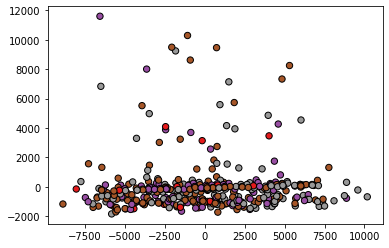

In [58]:
from sklearn.decomposition import PCA

data=hot_data
y=data.Stage
features=data.drop(columns=["Stage"])


fig=plt.figure()
ax = fig.add_subplot(1,1,1)
X_reduced = PCA(n_components=2).fit_transform(features)
ax.scatter(
    X_reduced[:, 0],
    X_reduced[:, 1],
    c=y,
    cmap=plt.cm.Set1,
    edgecolor="k",
    s=40,
)

